In [1]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import warnings

import torch
import torch.nn.functional as F
import torch.nn as nn
import scipy
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import matplotlib.font_manager
from matplotlib import rcParams
import scanpy as sc
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import sample_squidiff
from Squidiff.scrna_datasets import Drug_dose_encoder


In [2]:
double_drug_adata = sc.read_h5ad('datasets/comb_drug.h5ad')
double_drug_adata.shape

(9998, 78)

In [6]:
def run_sampler(model_path):
    sampler = sample_squidiff.sampler(
        model_path = model_path,#'diff_results/model.pt',
        gene_size = 78,
        output_dim = 78,
        use_drug_structure = False
    )
    single_drug_adata = sc.read_h5ad('datasets/single_drug.h5ad')
    z_sem = sampler.model.encoder(
        torch.tensor(single_drug_adata.X).to('cuda')
    )
    z_sem_ctl = z_sem[single_drug_adata.obs['Group']=='control'].mean(axis=0)
    z_sem_panobinostat = z_sem[single_drug_adata.obs['Group']=='panobinostat'].mean(axis=0)
    z_sem_erlotinib = z_sem[single_drug_adata.obs['Group']=='erlotinib'].mean(axis=0)
    z_sem_midostaurin = z_sem[single_drug_adata.obs['Group']=='midostaurin'].mean(axis=0)
    z_sem_dabrafenib = z_sem[single_drug_adata.obs['Group']=='dabrafenib'].mean(axis=0)
    z_sem_trametinib = z_sem[single_drug_adata.obs['Group']=='trametinib'].mean(axis=0)

    direct_z_panobinostat = z_sem_panobinostat - z_sem_ctl
    direct_z_erlotinib = z_sem_erlotinib - z_sem_ctl
    direct_z_midostaurin = z_sem_midostaurin - z_sem_ctl
    direct_z_dabrafenib = z_sem_dabrafenib - z_sem_ctl
    direct_z_trametinib = z_sem_trametinib - z_sem_ctl
    
    sample_trametinib_panobinostat= sampler.interp_with_direction(z_sem_origin = z_sem_ctl,
                                               gene_size = 78,
                                               direction = direct_z_panobinostat + direct_z_trametinib,
                                               scale = 1
                                              )
    sample_trametinib_erlotinib= sampler.interp_with_direction(z_sem_origin = z_sem_ctl,
                                                   gene_size = 78,
                                                   direction = direct_z_trametinib+direct_z_erlotinib,
                                                   scale = 1
                                                  )
    sample_trametinib_midostaurin= sampler.interp_with_direction(z_sem_origin = z_sem_ctl,
                                                   gene_size = 78,
                                                   direction = direct_z_trametinib+direct_z_midostaurin,
                                                   scale = 1
                                                  )
    sample_trametinib_dabrafenib= sampler.interp_with_direction(z_sem_origin = z_sem_ctl,
                                                   gene_size = 78,
                                                   direction = direct_z_trametinib+direct_z_dabrafenib,
                                                   scale = 1
                                                  )
    
    return sampler, sample_trametinib_panobinostat, sample_trametinib_erlotinib, sample_trametinib_midostaurin, sample_trametinib_dabrafenib
    


In [9]:
def add_pearsonr(model_path):
    sampler, sample_trametinib_panobinostat, sample_trametinib_erlotinib, sample_trametinib_midostaurin, sample_trametinib_dabrafenib = run_sampler(model_path=model_path) 

    r2_1, pearsonr_1 = sampler.cal_metric(sample_trametinib_panobinostat,  
                                    double_drug_adata[double_drug_adata.obs['Group']=='trametinib_panobinostat'])
    print(r2_1)
    print(pearsonr_1)




    r2_2, pearsonr_2 = sampler.cal_metric(sample_trametinib_dabrafenib,  
                                        double_drug_adata[double_drug_adata.obs['Group']=='trametinib_dabrafenib'])
    print(r2_2)
    print(pearsonr_2)


    r2_3, pearsonr_3 = sampler.cal_metric(sample_trametinib_erlotinib,  
                                        double_drug_adata[double_drug_adata.obs['Group']=='trametinib_erlotinib'])
    print(r2_3)
    print(pearsonr_3)

    r2_4, pearsonr_4 = sampler.cal_metric(sample_trametinib_midostaurin,  
                                        double_drug_adata[double_drug_adata.obs['Group']=='trametinib_midostaurin'])
    print(r2_4)
    print(pearsonr_4)  
    return pearsonr_1,pearsonr_2,pearsonr_3,pearsonr_4

In [11]:
r2_all_1=[]
pearsonr_all_1=[]
r2_all_2=[]
pearsonr_all_2=[]
r2_all_3=[]
pearsonr_all_3=[]
r2_all_4=[]
pearsonr_all_4=[]

pearsonr_1,pearsonr_2,pearsonr_3,pearsonr_4 = add_pearsonr(model_path='single_drug/model.pt') 
pearsonr_all_1.append(pearsonr_1)  
pearsonr_all_2.append(pearsonr_2)  
pearsonr_all_3.append(pearsonr_3)  
pearsonr_all_4.append(pearsonr_4) 
pearsonr_1,pearsonr_2,pearsonr_3,pearsonr_4 = add_pearsonr(model_path='single_drug2/model.pt') 
pearsonr_all_1.append(pearsonr_1)  
pearsonr_all_2.append(pearsonr_2)  
pearsonr_all_3.append(pearsonr_3)  
pearsonr_all_4.append(pearsonr_4)  
pearsonr_1,pearsonr_2,pearsonr_3,pearsonr_4 = add_pearsonr(model_path='single_drug3/model.pt') 
pearsonr_all_1.append(pearsonr_1)  
pearsonr_all_2.append(pearsonr_2)  
pearsonr_all_3.append(pearsonr_3)  
pearsonr_all_4.append(pearsonr_4)  


load model and diffusion...
diffusion num of steps =  1000
0.28834967538734646
0.77447256883753
0.561522063241604
0.869932023363958
0.3082797651401453
0.7671246416253787
-0.3446142972766313
0.596063564213694
load model and diffusion...
diffusion num of steps =  1000
0.1374980646219972
0.7463835970694892
0.5470102478512449
0.8531018925999658
0.4468987951648886
0.8165890037521242
-0.14728580383332313
0.6259873501870256
load model and diffusion...
diffusion num of steps =  1000
0.25671543978895295
0.7710744120764323
0.6612308626581691
0.8901690839226823
0.4664220767960393
0.8024735983046802
-0.14271380168761616
0.612179136753285


In [12]:
from statannotations.Annotator import Annotator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [24]:
all_

,0,1,2,3
0,0.774473,0.869932,0.767125,0.596064
1,0.746384,0.853102,0.816589,0.625987
2,0.771074,0.890169,0.802474,0.612179


Text(0.5, 0, '')

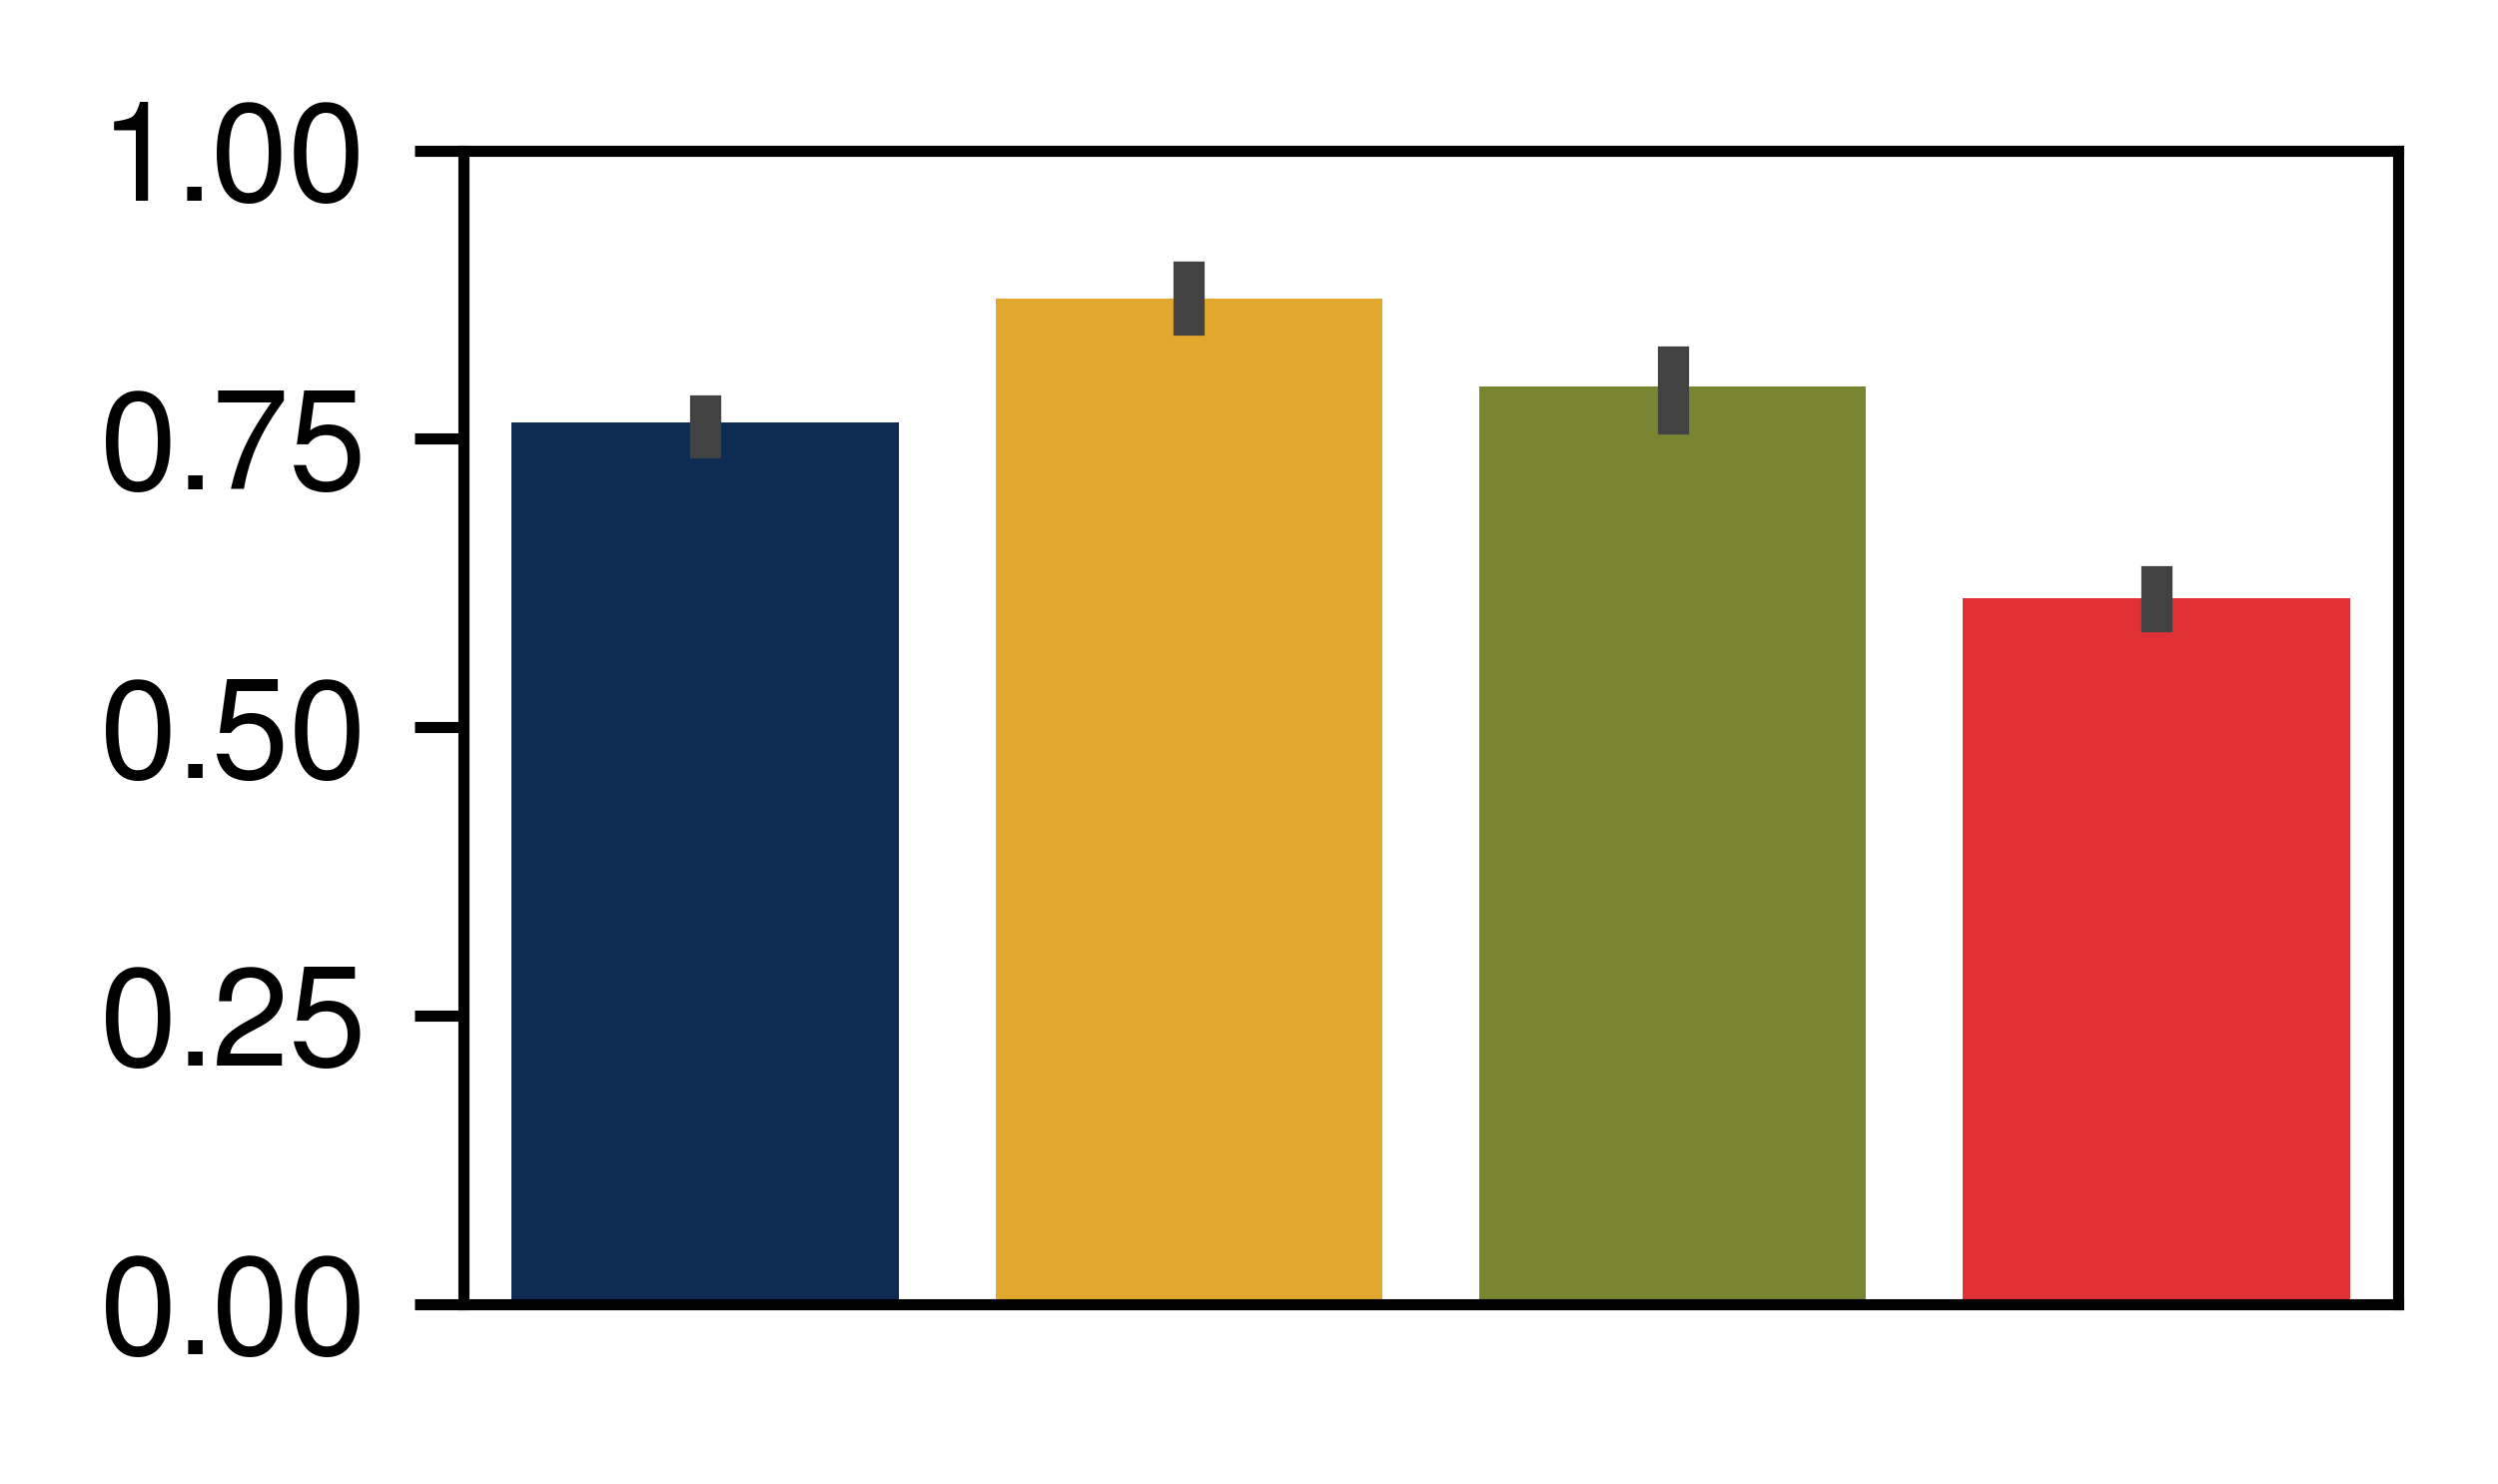

In [27]:
all_ = pd.concat([pd.DataFrame(pearsonr_all_1),
                  pd.DataFrame(pearsonr_all_2),
                  pd.DataFrame(pearsonr_all_3),
                  pd.DataFrame(pearsonr_all_4),
                 ], axis=1)
all_.columns=[0,1,2,3]
custom_palette = dict(zip([0,1,2,3], 
                          ['#01295F','#FFB30F','#849324','#FD151B']))


# Create the boxplot
fig, ax = plt.subplots(1, 1, dpi=1000, figsize=(2.5, 1.5))
g1 = sns.barplot(data=all_, 
                 #x=x,y=y,
                 ax=ax,
                palette=custom_palette, 

                )
plt.xticks([])
plt.ylim([0,1])
plt.ylabel('')
plt.xlabel('')


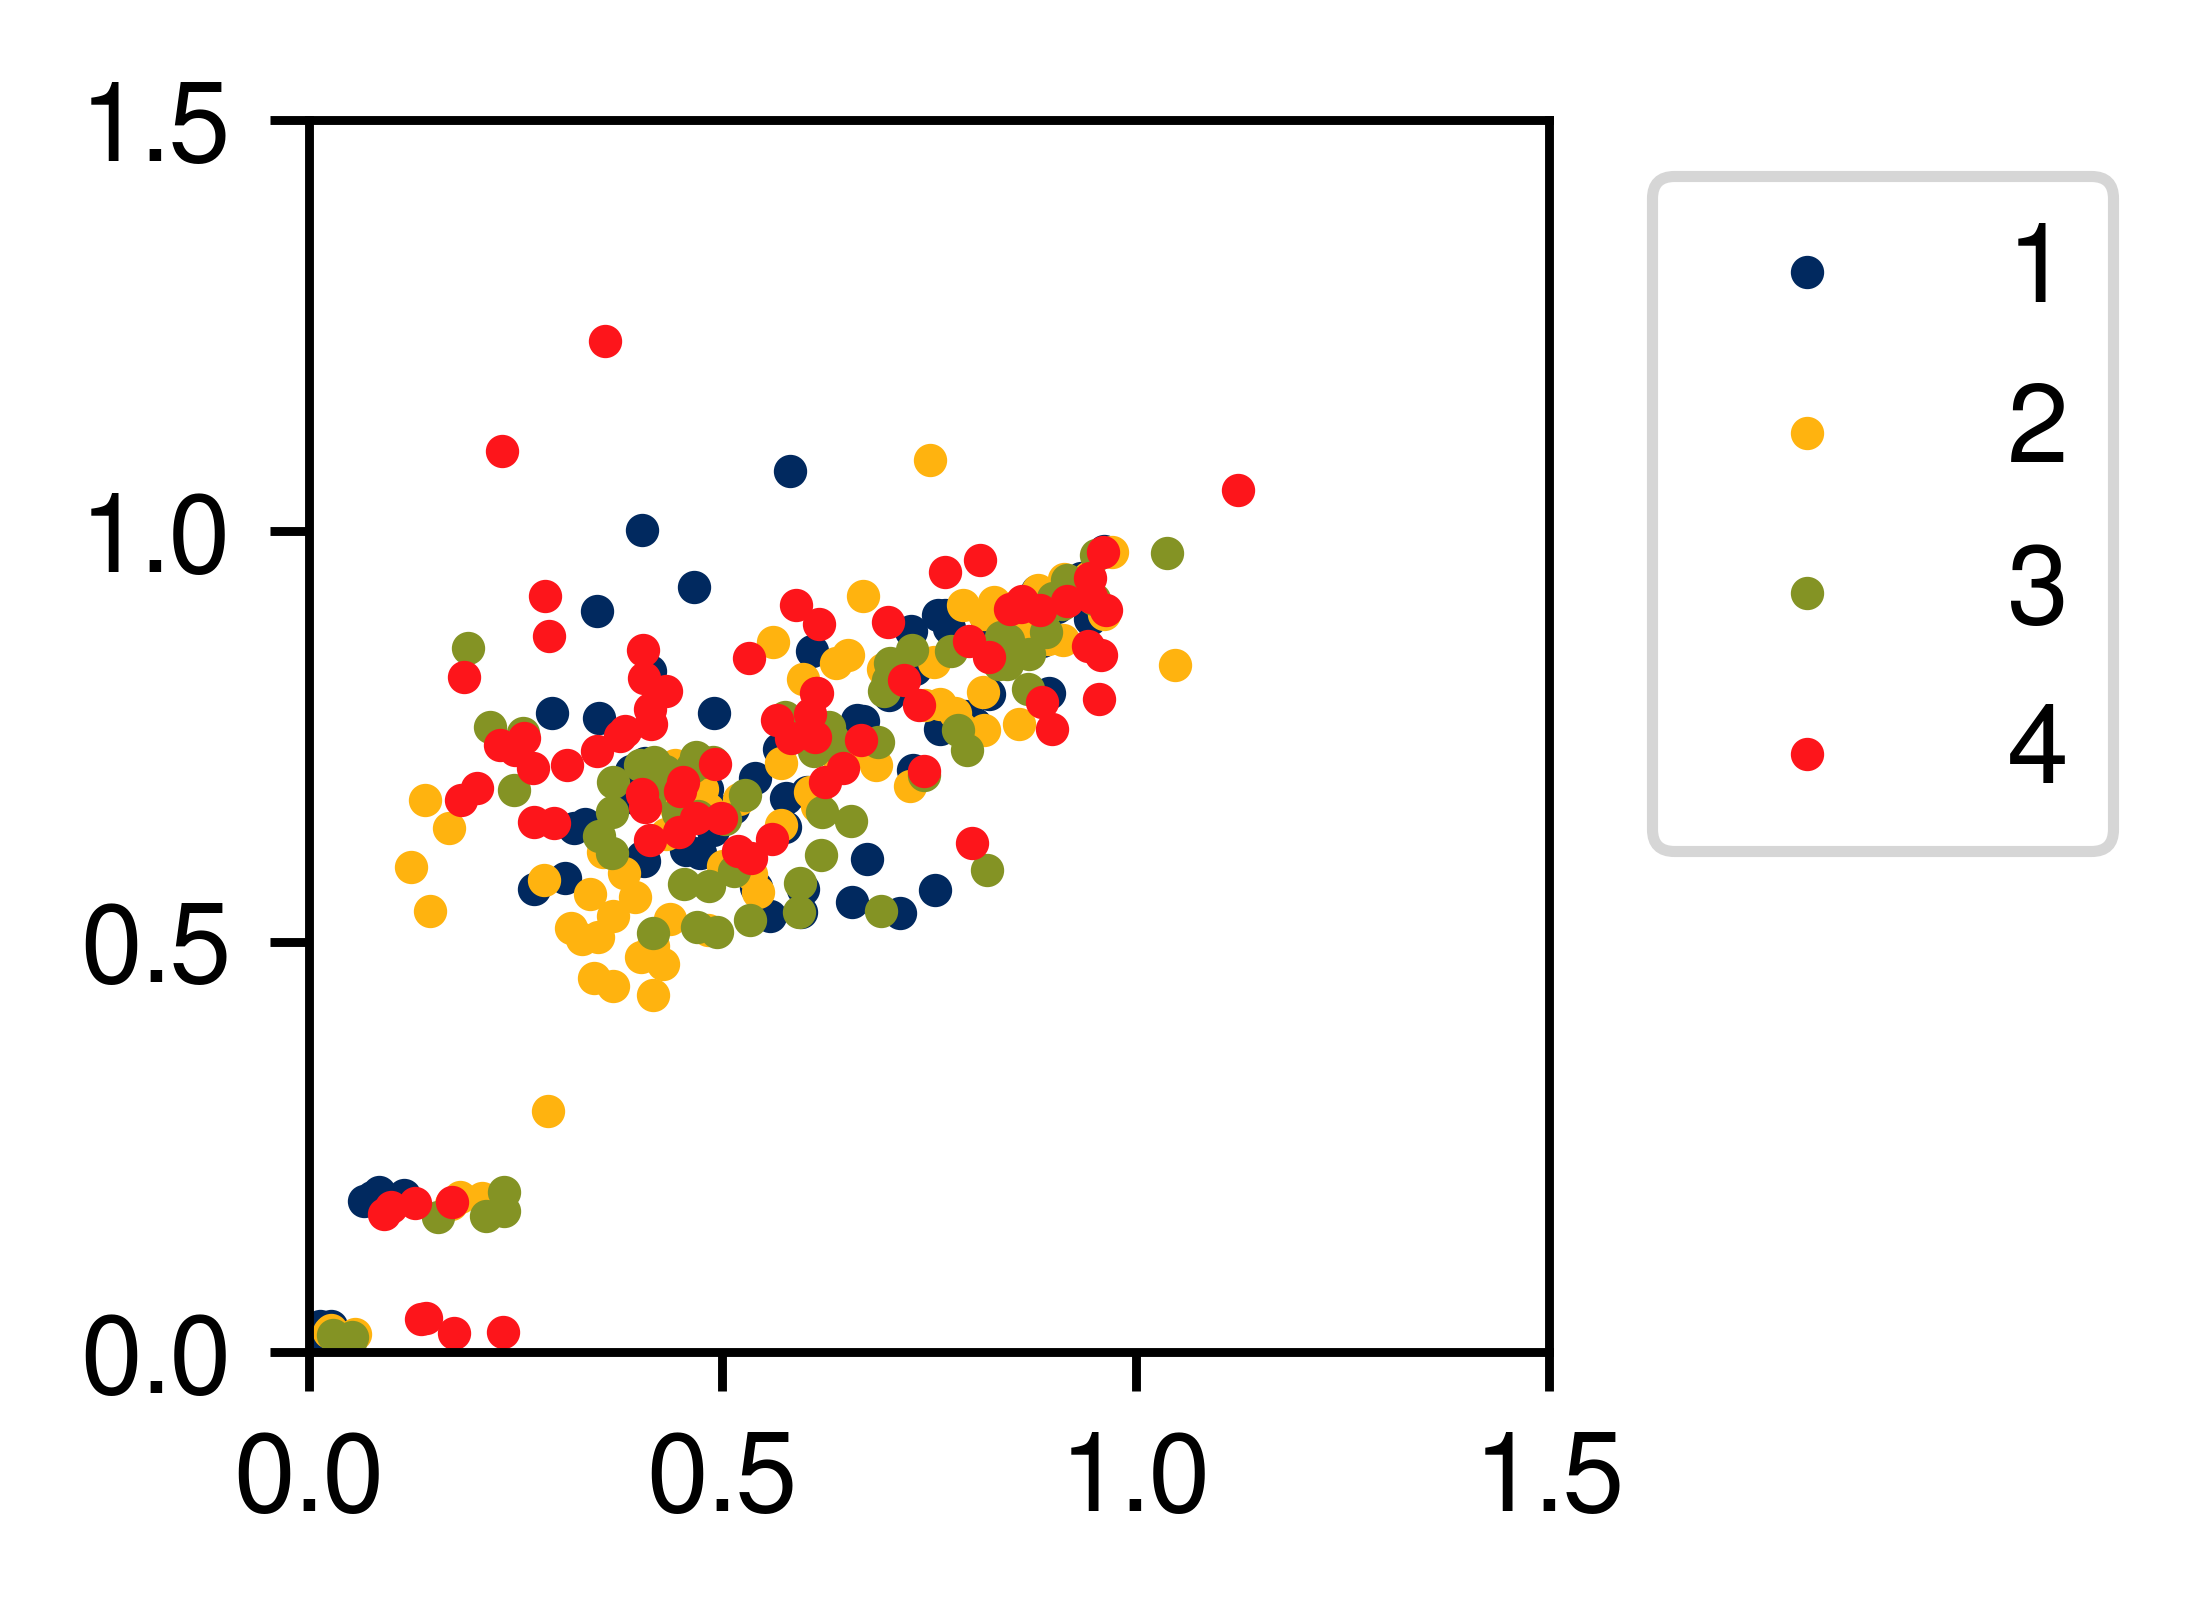

In [99]:
plt.subplots(1,1,figsize=(2,2),dpi=800)
plt.scatter(sample_trametinib_panobinostat.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group']=='trametinib_panobinostat'].X.mean(axis=0),
            s=4,
            c='#01295F'
           )
plt.scatter(sample_trametinib_dabrafenib.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group']=='trametinib_dabrafenib'].X.mean(axis=0),
            s=4,
            c='#FFB30F'
           )
plt.scatter(sample_trametinib_erlotinib.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group']=='trametinib_erlotinib'].X.mean(axis=0),
            s=4,
            c='#849324'
           )
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.scatter(sample_trametinib_midostaurin.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group']=='trametinib_midostaurin'].X.mean(axis=0),
            s=4,
            c='#FD151B'
           )
plt.legend(['1','2','3','4'],bbox_to_anchor=(1.5,1))

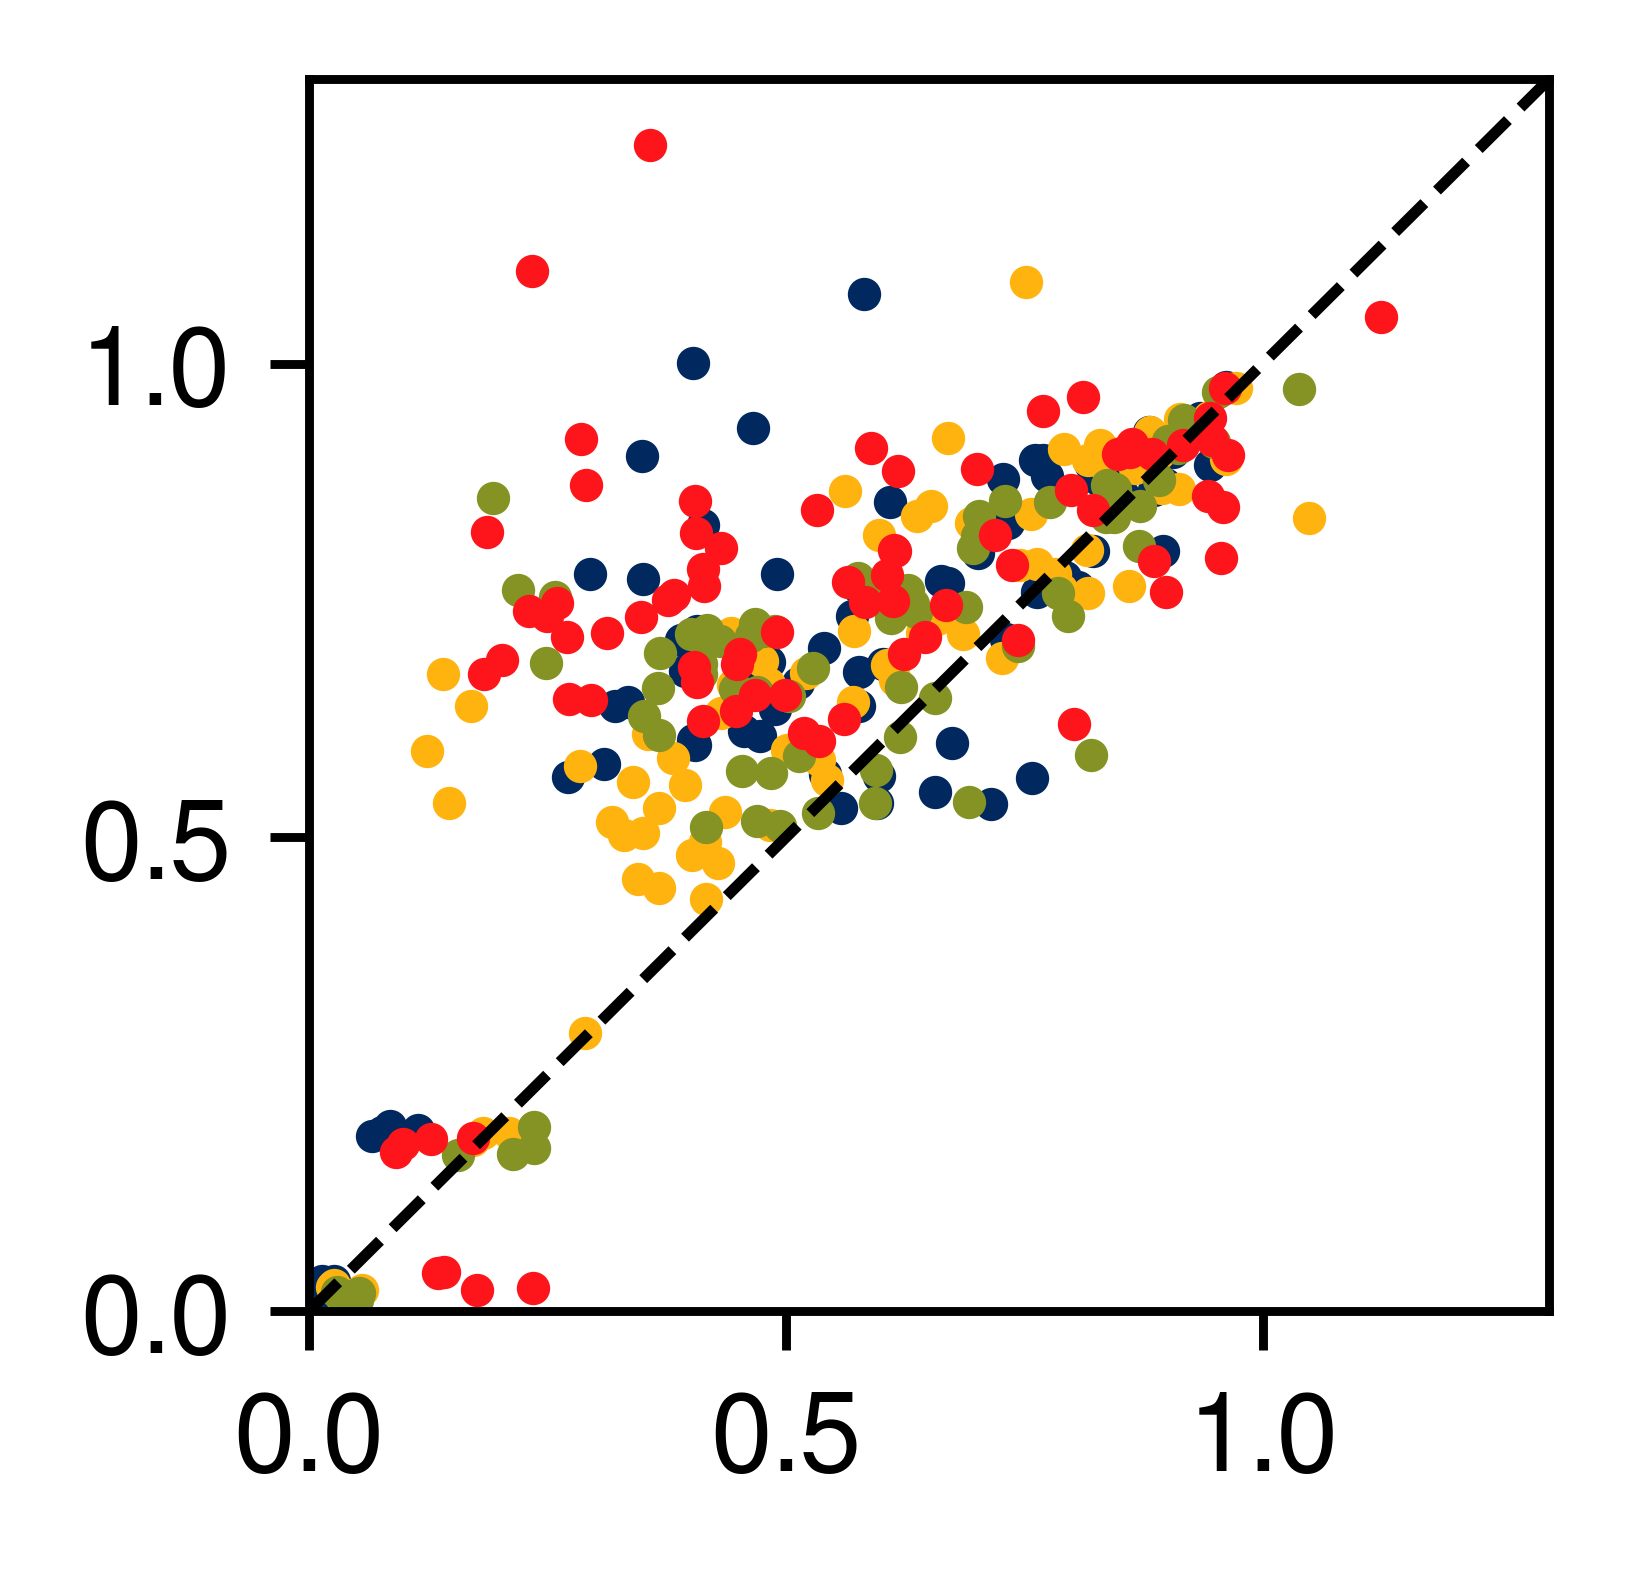

In [102]:
import matplotlib.pyplot as plt

plt.subplots(1, 1, figsize=(2, 2), dpi=800)

# Scatter plot for 'trametinib_panobinostat'
plt.scatter(sample_trametinib_panobinostat.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group'] == 'trametinib_panobinostat'].X.mean(axis=0),
            s=4, c='#01295F')

# Scatter plot for 'trametinib_dabrafenib'
plt.scatter(sample_trametinib_dabrafenib.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group'] == 'trametinib_dabrafenib'].X.mean(axis=0),
            s=4, c='#FFB30F')

# Scatter plot for 'trametinib_erlotinib'
plt.scatter(sample_trametinib_erlotinib.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group'] == 'trametinib_erlotinib'].X.mean(axis=0),
            s=4, c='#849324')

# Scatter plot for 'trametinib_midostaurin'
plt.scatter(sample_trametinib_midostaurin.detach().cpu().mean(axis=0),
            double_drug_adata[double_drug_adata.obs['Group'] == 'trametinib_midostaurin'].X.mean(axis=0),
            s=4, c='#FD151B')

# Set axis limits
plt.xlim([0, 1.3])
plt.ylim([0, 1.3])

# Plot the line y = x
plt.plot([0, 1.3], [0, 1.3], color='black', linestyle='--', linewidth=1)

# Display the plot
plt.show()


In [105]:
double_drug_adata[double_drug_adata.obs['Group'] == 'trametinib_midostaurin'].X.mean(axis=0).argmax()

68

In [107]:
double_drug_adata.var_names[68]

'intensity-cell-Ki67-mean'